<a href="https://colab.research.google.com/github/arjunp17/perceptron/blob/main/Perceptron__model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Export requirements file from the local machine

In [ ]:
#@title Installing python packages from the requirement file
!pip install -r '/content/requirements.txt'

In [ ]:
#@title Importing required python packages
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import scipy 
import pandas as pd
import jupyter
import ipykernel
import tensorflow as tf
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds

# Export data csv file from the local machine

In [ ]:
#@title Loading data and extracting feature and label
data = pd.read_csv('/content/data2.csv')
data = data.values
feature = data[:,0:5]
label = data[:,-1]

In [ ]:
#@title Checking class balance
positive = []
negative = []
for i in range(0,len(feature)):
  if label[i] == 1.:
    positive.append(feature[i])
  else:
    negative.append(feature[i])


positive = np.array(positive)
negative = np.array(negative)
print('No. of positive class samples: ', len(positive))
print('No. of negative class samples: ', len(negative))

No. of positive class samples:  2500
No. of negative class samples:  2500


 Data is balanced!

<function matplotlib.pyplot.show(close=None, block=None)>

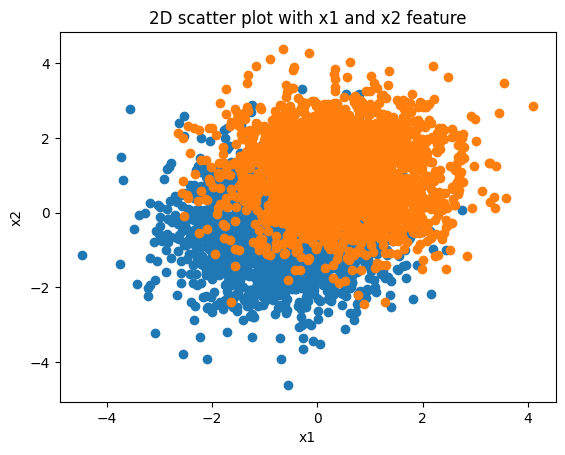

In [ ]:
#@title Plotting data with x1 and x2 feature
import matplotlib.pyplot as plt

plt.scatter(positive[:,0], positive[:,1])
plt.scatter(negative[:,0], negative[:,1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('2D scatter plot with x1 and x2 feature')
plt.show


Inference - With x1 and x2 features, data is not separable

In [ ]:
#@title Splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.33, random_state=42)

X_train = tf.cast(X_train, dtype='float32')
y_train = tf.cast(tf.expand_dims(y_train, axis=-1), dtype='float32')
X_test = tf.cast(X_test, dtype='float32')
y_test = tf.cast(tf.expand_dims(y_test, axis=-1), dtype='float32')

2023-03-12 16:44:07.890711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


##The Perceptron model 

$f(x) = 1$, if  $W^Tx + b  >= 0$

$f(x) = -1$, if  $W^Tx + b  < 0$

where W and b are the parameters of the model

In [ ]:
#@title Defining the Perceptron model with Keras functional API
input_data = tf.keras.layers.Input(shape = (5,))
x = tf.keras.layers.Dense(1)(input_data)
x = tf.keras.layers.Lambda(lambda x: tf.where(x >= 0, 1.0, -1.0))(x)
model = tf.keras.models.Model(input_data, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Looking at the model prediction for a random input
print('Random input: ', [0.1,2.1, 3.4, 0.5, 0.2])
print('Model prediction: ', model.predict([[0.1,2.1, 3.4, 0.5, 0.2]]))

Random input:  [0.1, 2.1, 3.4, 0.5, 0.2]
1/1 [==============================] - 0s 322ms/step
Model prediction:  [[-1.]]


In [ ]:
#@title Looking at the randomly initialised weight parameters (W and b) - before training
print('Initial weights for W: ', model.variables[0].numpy())
print('Initial weights for b: ', model.variables[1].numpy())

Initial weights for W:  [[ 0.8591237 ]
 [ 0.9580622 ]
 [-0.80295897]
 [ 0.6286335 ]
 [-0.7844012 ]]
Initial weights for b:  [0.]


In [ ]:
#@title Performance of the randomly initialised model on the test data! (Before training)
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_pred, y_test))

52/52 [==============================] - 0s 1ms/step
Accuracy:  0.22181818181818183


##Learning algorithm definition - 

$W:= \frac{1}{M}\sum_{i=1}^{M}\biggl(W + \bigl(y_{i} - \hat{y}_{i}\bigl)x_i/2\biggl)$

$b:= \frac{1}{M}\sum_{i=1}^{M}\biggl(b + \bigl(y_{i} - \hat{y}_{i}\bigl)/2\biggl)$


where $M$ is the mini batch size

In [ ]:
#@title Custom weight update function according to the given learning algorithm
def custom_weight_update(w, b, x, y_t, y_p):
  y_diff = y_t - y_p
  d_w = tf.reduce_mean(tf.transpose(tf.repeat(w, x.shape[0],-1),[1,0]) + tf.multiply(y_diff, x/2), axis=0)
  d_b = tf.reduce_mean(b + (y_t - y_p)/2, axis=0)
  return d_w, d_b

In [ ]:
#@title Testing the custom weight update function with a random batch of 3 samples
x_custom_test = X_test[:3, :]
y_custom_test = y_test[:3, :]

d_w_test, d_b_test = custom_weight_update(model.variables[0], model.variables[1], x_custom_test, y_custom_test, model.predict(x_custom_test))
print('Updated w: ', d_w_test.numpy())
print('Updated b: ', d_b_test.numpy())

1/1 [==============================] - 0s 29ms/step
Updated w:  [ 0.8591237   0.9580622  -0.80295897  0.6286335  -0.7844012 ]
Updated b:  [0.]


In [ ]:
#@title Defining the loss function - Mean square error
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

In [ ]:
#@title Model weight updation function

def train(model, x, y):

  dw, db = custom_weight_update(model.variables[0], model.variables[1], x, y, model.predict(x))

  model.variables[0].assign(tf.expand_dims(dw, axis=-1))
  model.variables[1].assign(db)

In [ ]:
#@title Model train function
def training_loop(model, x_samples, y_samples, batch_size, X_test, y_test):
#Training over epochs with weights being updated in every batch
  for epoch in epochs:
    total_batch_loss = []
    for batch in range(0, len(x_samples), batch_size):
      x_batch = x_samples[batch:batch+batch_size, :]
      y_batch = y_samples[batch:batch+batch_size]
      train(model, x_batch, y_batch)
      weights.append(model.variables[0].numpy())
      biases.append(model.variables[1].numpy())
      batch_loss = loss(y_batch, model(x_batch))
      total_batch_loss.append(batch_loss)
    train_loss = np.mean(total_batch_loss)
    y_pred = model.predict(X_test)
    print(f"Epoch {epoch:2d}:")
    print('wights: ', model.variables[0].numpy())
    print('bias: ', model.variables[1].numpy())
    print('loss: ', train_loss)
    print('Eval accuracy at the end of each epoch: ', accuracy_score(y_pred, y_test))

In [ ]:
#@title Training for 10 epochs and with 32 samples as the batch size

# Weights are stored for later inspection
weights = []
biases = []
epochs = range(10)
print(f"Starting:")
training_loop(model, X_train, y_train, 32, X_test, y_test)

Starting:
52/52 [==============================] - 0s 1ms/step
Epoch  0:
wights:  [[-0.31450573]
 [-0.40338534]
 [-0.12008452]
 [-0.916968  ]
 [-0.53578234]]
bias:  [0.01420455]
loss:  0.06482684
Eval accuracy at the end of each epoch:  0.9781818181818182
52/52 [==============================] - 0s 2ms/step
Epoch  1:
wights:  [[-0.20148581]
 [-0.35442117]
 [-0.02419821]
 [-0.49700966]
 [-0.28484762]]
bias:  [0.12215905]
loss:  0.044588745
Eval accuracy at the end of each epoch:  0.9793939393939394
52/52 [==============================] - 0s 1ms/step
Epoch  2:
wights:  [[-0.13308305]
 [-0.2219012 ]
 [-0.04834203]
 [-0.2567003 ]
 [-0.15395059]]
bias:  [0.10511355]
loss:  0.041666668
Eval accuracy at the end of each epoch:  0.9727272727272728
52/52 [==============================] - 0s 2ms/step
Epoch  3:
wights:  [[-0.1346404 ]
 [-0.20434408]
 [-0.05692619]
 [-0.23696145]
 [-0.1203369 ]]
bias:  [0.05681805]
loss:  0.05
Eval accuracy at the end of each epoch:  0.973939393939394
52/52 [====

In [ ]:
#@title Looking at the optimised weights of the model! - after training
print('Optimised weights for W: ', model.variables[0].numpy())
print('Optimised weights for b: ', model.variables[1].numpy())

Optimised weights for W:  [[-0.19414662]
 [-0.2653248 ]
 [-0.04552729]
 [-0.24134754]
 [-0.11906765]]
Optimised weights for b:  [0.07954507]


In [ ]:
#@title Model evaluation
y_pred = model.predict(X_test)
print('Eval Accuracy: ', accuracy_score(y_pred, y_test))

52/52 [==============================] - 0s 3ms/step
Eval Accuracy:  0.9703030303030303


# References

* [Introduction to gradients and automatic differentiation - Tensorflow](https://www.tensorflow.org/guide/autodiff)

* [Basic training loops - Tensorflow](https://www.tensorflow.org/guide/basic_training_loops)


